# Extra Assignment — Stochastic Calculus  
### Simulation of OU Process, CIR Model, and Feynman–Kac PDE  

**Name:** Rishabh Kumar  
**Course:** Math 467 — Stochastic Calculus  
**Instructor:** Prof. Daniel Conus  
**Semester:** Fall 2025  

This notebook contains full solutions, simulations, and explanations for Problems 1–3 in the extra assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Simulate Brownian Motion
def simulate_brownian(T, N):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(N)
    W = np.concatenate(([0.0], np.cumsum(dW)))
    t = np.linspace(0, T, N + 1)
    return t, W

# Euler-Maruyama for OU
def simulate_OU_euler(a, sigma, x0, T, N, W):
    dt = T / N
    X = np.zeros(N + 1)
    X[0] = x0
    for n in range(N):
        dW = W[n+1] - W[n]
        X[n+1] = X[n] + (a - X[n]) * dt + sigma * dW
    return X

def monte_carlo_OU(a, sigma, x0, T, N, M):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(M, N)
    X = np.zeros((M, N + 1))
    X[:,0] = x0
    for n in range(N):
        X[:,n+1] = X[:,n] + (a - X[:,n]) * dt + sigma * dW[:,n]
    return X[:,-1]

# Euler-Maruyama for CIR
def simulate_CIR_euler(a, sigma, x0, T, N, W):
    dt = T / N
    X = np.zeros(N + 1)
    X[0] = x0
    for n in range(N):
        dW = W[n+1] - W[n]
        X_pos = max(X[n], 0.0)
        X[n+1] = X[n] + (a - X[n]) * dt + sigma * np.sqrt(X_pos) * dW
    return X

def monte_carlo_CIR(a, sigma, x0, T, N, M):
    dt = T / N
    dW = np.sqrt(dt) * np.random.randn(M, N)
    X = np.zeros((M, N + 1))
    X[:,0] = x0
    for n in range(N):
        X_pos = np.clip(X[:,n], a_min=0, a_max=None)
        X[:,n+1] = X[:,n] + (a - X[:,n]) * dt + sigma * np.sqrt(X_pos) * dW[:,n]
    return X[:,-1]

# Feynman-Kac process simulation
def estimate_f_at_time(t0, xs, T_final, N, M):
    H = T_final - t0
    dt = H / N
    f_vals = np.zeros_like(xs)
    for i, x0 in enumerate(xs):
        X = np.full(M, x0)
        for _ in range(N):
            dW = np.sqrt(dt) * np.random.randn(M)
            X += (1 - X) * dt + dW
        f_vals[i] = np.mean(np.exp(X))
    return f_vals

# Problem 1 — Simulation of the Ornstein–Uhlenbeck Process

We consider the OU SDE:

$$
dX_t = (a - X_t)\, dt + \sigma\, dW_t, \qquad X_0 = x_0.
$$

We simulate:

1. A Brownian path.  
2. One OU trajectory using Euler–Maruyama.  
3. Monte Carlo estimates of the long-term mean and variance.  
4. Compare numerical results with theoretical formulas:

- Stationary mean: $ \mathbb{E}[X_\infty] = a $  
- Stationary variance: $ \mathrm{Var}(X_\infty) = \dfrac{\sigma^2}{2} $

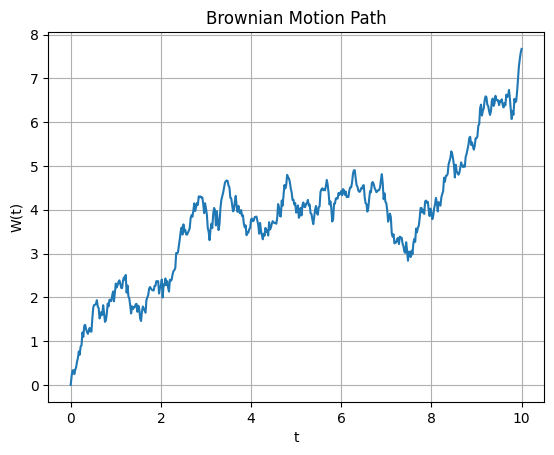

In [6]:
# Problem 1(a)

T = 10
N = 500
a = 1
sigma = 1
x0 = 5
M = 1000

t, W = simulate_brownian(T, N)

plt.plot(t, W)
plt.title("Brownian Motion Path")
plt.xlabel("t")
plt.ylabel("W(t)")
plt.grid(True)
plt.show()

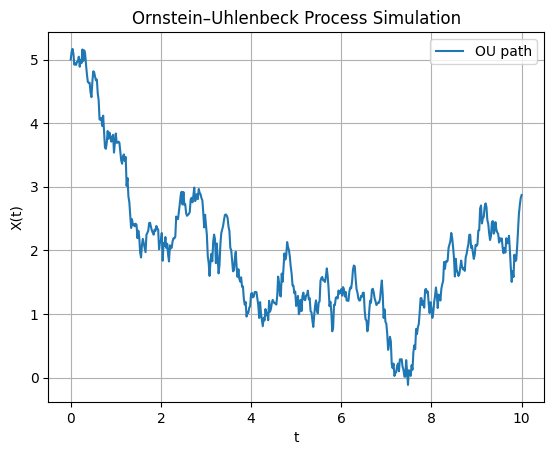

In [7]:
# Problem 1(b)

X_ou = simulate_OU_euler(a, sigma, x0, T, N, W)

plt.plot(t, X_ou, label="OU path")
plt.title("Ornstein–Uhlenbeck Process Simulation")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()

### Problem 1(c) — How to improve the numerical scheme?

To increase accuracy:

- **Decrease the timestep** $dt = T/N$ (i.e., use larger $N$), which reduces discretization error.  
- Use a **higher-order time discretization**, such as the Milstein scheme, instead of plain Euler–Maruyama.  
- For the OU process in particular, we can use its **closed-form exact solution**, which eliminates the time-discretization bias entirely and only leaves Monte Carlo (statistical) error.

In [8]:
# Problem 1(d)

samples = monte_carlo_OU(a, sigma, x0, T, N, M)
mc_mean = samples.mean()
mc_var  = samples.var(ddof=1)

theo_mean = a
theo_var  = sigma**2 / 2

print("Monte Carlo Mean:", mc_mean)
print("Theoretical Mean:", theo_mean)
print("Monte Carlo Variance:", mc_var)
print("Theoretical Variance:", theo_var)

Monte Carlo Mean: 1.000567432670552
Theoretical Mean: 1
Monte Carlo Variance: 0.5361128909320372
Theoretical Variance: 0.5


# Problem 2 — Simulation of the CIR Model

We now consider the CIR SDE:

$$
dX_t = (a - X_t)\, dt + \sigma \sqrt{X_t}\, dW_t, \qquad X_0 = x_0.
$$

This is another common model for interest rates. In this problem we:

1. Simulate a CIR trajectory using the **same Brownian motion** as in Problem 1 and compare it visually to the OU trajectory.  
2. Perform Monte Carlo simulations to estimate the long-term expectation and variance of the CIR process and compare them with the OU results.  
3. Explain why the Euler scheme can run into numerical problems (e.g., negative values) when the parameters are larger.

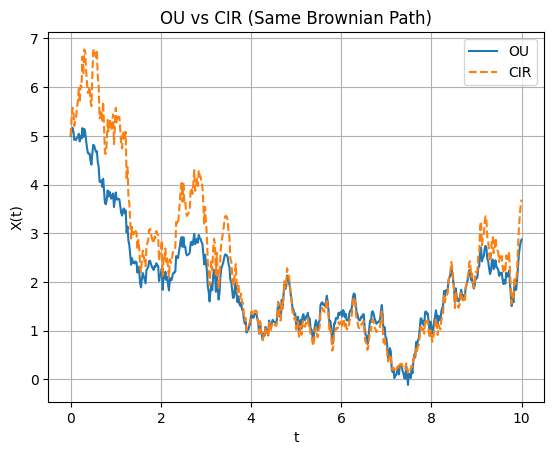

In [11]:
# Problem 2(a)

a_CIR = a_OU = 1
sigma_CIR = sigma_OU = 1
x0_CIR = x0_OU = 5

X_ou = simulate_OU_euler(a_OU, sigma_OU, x0_OU, T, N, W)
X_cir = simulate_CIR_euler(a_CIR, sigma_CIR, x0_CIR, T, N, W)

plt.plot(t, X_ou, label="OU")
plt.plot(t, X_cir, '--', label="CIR")
plt.title("OU vs CIR (Same Brownian Path)")
plt.xlabel("t")
plt.ylabel("X(t)")
plt.grid(True)
plt.legend()
plt.show()

In [12]:
# Problem 2(b)

# Numerical parameters for this part:
a = 0.04
sigma = 0.01
x0 = 0.05
M = 1000

cir_samples = monte_carlo_CIR(a, sigma, x0, T, N, M)

print("CIR Monte Carlo Mean:", cir_samples.mean())
print("CIR Monte Carlo Variance:", cir_samples.var(ddof=1))

# Same OU parameters for comparison
ou_samples = monte_carlo_OU(a, sigma, x0, T, N, M)

print("OU Monte Carlo Mean:", ou_samples.mean())
print("OU Monte Carlo Variance:", ou_samples.var(ddof=1))

CIR Monte Carlo Mean: 0.04001729376986804
CIR Monte Carlo Variance: 2.040900865068036e-06
OU Monte Carlo Mean: 0.039926396665811645
OU Monte Carlo Variance: 4.772445115124469e-05


### Problem 2(c) — Why does Euler fail for CIR with larger parameters?

The Euler–Maruyama update for the CIR SDE is

$$
X_{n+1}
= X_n + (a - X_n)\, \Delta t + \sigma \sqrt{X_n}\, \Delta W_n.
$$

Here $\Delta W_n \sim \mathcal{N}(0, \Delta t)$. When $\Delta W_n$ is sufficiently negative, the stochastic term  
$\sigma \sqrt{X_n}\, \Delta W_n$ can be large and negative, pushing $X_{n+1}$ **below zero**, even though the true CIR process is non-negative.

Once $X_{n+1} < 0$, the square root $\sqrt{X_{n+1}}$ is not well-defined in the real sense, and the numerical scheme can produce NaNs or complex values. This issue becomes more pronounced when the parameters $a$, $\sigma$, or the step size $\Delta t$ are large, because:

- The drift and diffusion terms are larger in magnitude.  
- The Gaussian increments $\Delta W_n$ can produce larger swings in one step.

To avoid this, one typically uses **positivity-preserving schemes**, such as:

- Full-truncation Euler (replacing $X_n$ by $\max(X_n, 0)$ in the diffusion term).  
- More sophisticated schemes (e.g., exact sampling based on the noncentral chi-square distribution for CIR).

# Problem 3 — Feynman–Kac PDE with Numerical Simulation

We consider the PDE

$$
\frac{\partial f}{\partial t}(t, x)
+ (1 - x)\,\frac{\partial f}{\partial x}(t, x)
+ \frac{1}{2}\,\frac{\partial^2 f}{\partial x^2}(t, x)
= 0,
$$

with terminal condition

$$
f(\ln 2, x) = e^x.
$$

By the Feynman–Kac theorem, this PDE corresponds to a stochastic process and an expectation representation that we will identify in part (a).

## Problem 3(a) — Identify the SDE and the Feynman–Kac Expectation

To match the PDE with the Feynman–Kac formula, we compare the PDE

$$
f_t + (1 - x) f_x + \frac{1}{2} f_{xx} = 0
$$

to the general form

$$
f_t + b(x) f_x + \frac{1}{2}\sigma(x)^2 f_{xx} - c(t,x) f = 0.
$$

From this:

- The drift is:  
  $$ b(x) = 1 - x $$
- The diffusion coefficient is:  
  $$ \sigma(x) = 1 $$
- There is **no potential term**, so  
  $$ c(t,x) = 0 $$
- Terminal payoff:  
  $$ g(x) = e^x $$
- Terminal time:  
  $$ T = \ln 2 $$

Thus the associated SDE is

$$
dX_s = (1 - X_s)\,ds + dW_s,
\qquad X_t = x.
$$

By Feynman–Kac, the PDE solution is

$$
f(t,x) = \mathbb{E}\!\left[ e^{X_{\ln 2}} \mid X_t = x \right].
$$

In particular,

$$
f(0,x) = \mathbb{E}\!\left[ e^{X_{\ln 2}} \mid X_0 = x \right].
$$

## Problem 3(b) — Numerical Approximation of \( f(0, x) \)

To approximate

$$
f(0,x) = \mathbb{E}\!\left[ e^{X_{\ln 2}} \mid X_0 = x \right],
$$

we simulate the SDE

$$
dX_s = (1 - X_s)\,ds + dW_s
$$

using Euler–Maruyama on the interval \( [0, \ln 2] \).

### Euler–Maruyama Discretization

Let \( T = \ln 2 \), \( N \) steps, \( \Delta t = T/N \).

For each path:

$$
X_{n+1}
= X_n + (1 - X_n)\,\Delta t + \Delta W_n,
\qquad
\Delta W_n \sim \mathcal{N}(0, \Delta t).
$$

At final time \( T \), the payoff is \( e^{X_T} \).

### Monte Carlo Approximation

For fixed \(x\):

1. Simulate \( M \) independent paths.
2. Compute \( e^{X_T^{(m)}} \) for each path.
3. Estimate  
   $$
   f(0,x) \approx \frac{1}{M} \sum_{m=1}^M e^{X_T^{(m)}}.
   $$

We do this for 20 uniformly spaced points in the interval \( [0,2] \).

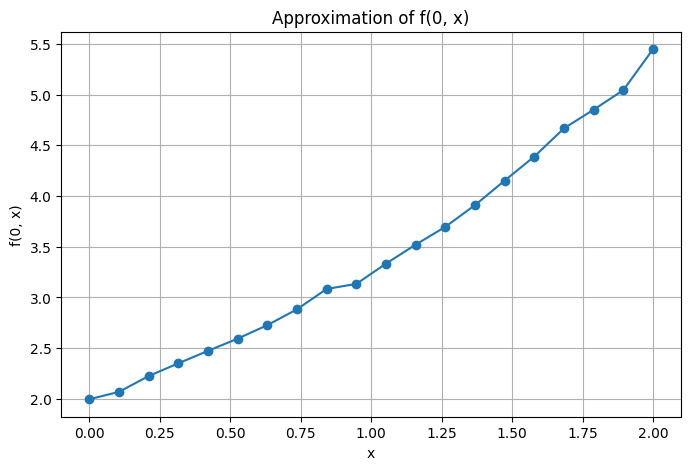

array([1.99656853, 2.06902887, 2.22516987, 2.35046457, 2.47350262,
       2.59379068, 2.72687082, 2.88302496, 3.08396329, 3.13329669,
       3.33318304, 3.520426  , 3.6961472 , 3.91022493, 4.15177005,
       4.3892831 , 4.66681306, 4.85149439, 5.04307713, 5.44711686])

In [16]:
def estimate_f_at_time(t0, xs, T_final, N, M):
    H = T_final - t0
    dt = H / N
    f_vals = np.zeros_like(xs)

    for i, x0 in enumerate(xs):
        X = np.full(M, x0)
        for _ in range(N):
            dW = np.sqrt(dt) * np.random.randn(M)
            X += (1 - X) * dt + dW
        f_vals[i] = np.mean(np.exp(X))
    
    return f_vals

# Parameters
T_final = np.log(2.0)
N = 1000
M = 5000
xs = np.linspace(0, 2, 20)

# Compute numerical f(0,x)
f0_vals = estimate_f_at_time(0.0, xs, T_final, N, M)

plt.figure(figsize=(8,5))
plt.plot(xs, f0_vals, marker='o')
plt.title("Approximation of f(0, x)")
plt.xlabel("x")
plt.ylabel("f(0, x)")
plt.grid(True)
plt.show()

f0_vals

## Problem 3(c) — How to Estimate \( f(0.1, x) \)

We again use the Feynman–Kac representation:

$$
f(t,x) = \mathbb{E}\!\left[ e^{X_{\ln 2}} \mid X_t = x \right].
$$

To compute \( f(0.1,x) \), the remaining horizon is:

$$
H = \ln 2 - 0.1.
$$

We simulate the same SDE:

$$
dX_s = (1 - X_s)\,ds + dW_s,
$$

starting from \( X_{0.1} = x \), which is equivalent in distribution to:

$$
\tilde{X}_0 = x, \qquad 
d\tilde{X}_u = (1 - \tilde{X}_u)\,du + dW_u,
\quad u \in [0, H].
$$

Then

$$
f(0.1,x) = \mathbb{E}\!\left[ e^{\tilde{X}_H} \right].
$$

Thus the same Monte Carlo algorithm from part (b) applies, only with a shorter time horizon.

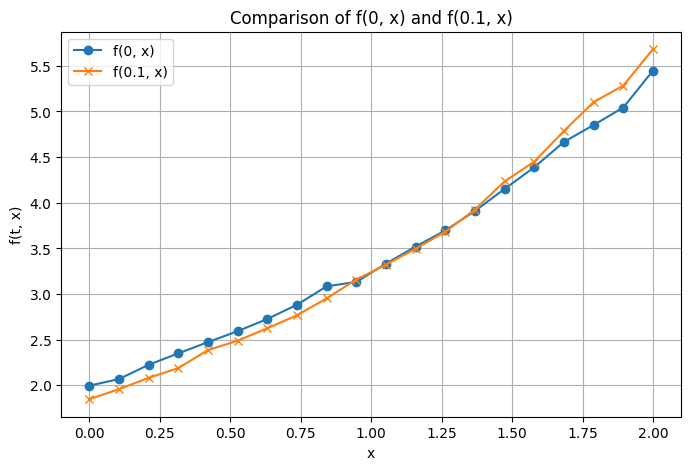

array([1.84800025, 1.95828121, 2.08212593, 2.18867367, 2.38615822,
       2.4892599 , 2.62484733, 2.76795479, 2.95299107, 3.1584051 ,
       3.32211674, 3.49652307, 3.68276669, 3.92584599, 4.23453239,
       4.45063845, 4.78566178, 5.10268287, 5.28312257, 5.6815152 ])

In [17]:
f01_vals = estimate_f_at_time(0.1, xs, T_final, N, M)

plt.figure(figsize=(8,5))
plt.plot(xs, f0_vals, marker='o', label="f(0, x)")
plt.plot(xs, f01_vals, marker='x', label="f(0.1, x)")
plt.title("Comparison of f(0, x) and f(0.1, x)")
plt.xlabel("x")
plt.ylabel("f(t, x)")
plt.grid(True)
plt.legend()
plt.show()

f01_vals

## Bonus — Explicit Formula for \( f(0,x) \)

The SDE
$$
dX_t = (1 - X_t)\,dt + dW_t
$$
is an Ornstein–Uhlenbeck (OU) process with mean-reversion speed \(1\), long-run mean \(1\), and volatility \(1\).

The OU process has the explicit solution
$$
X_t = 1 + (x - 1)e^{-t} + \int_0^t e^{-(t-s)}\, dW_s,
$$
so \(X_t\) is Gaussian with

- mean  
  $$
  \mathbb{E}[X_t] = 1 + (x - 1)e^{-t},
  $$
- variance  
  $$
  \mathrm{Var}(X_t) = \int_0^t e^{-2(t-s)}\,ds 
  = \frac{1 - e^{-2t}}{2}.
  $$

For a Gaussian random variable \(Z \sim \mathcal{N}(\mu,\sigma^2)\) we have
$$
\mathbb{E}[e^{Z}] = \exp\!\left(\mu + \frac{\sigma^2}{2}\right).
$$

We need
$$
f(0,x) = \mathbb{E}[e^{X_T}], \qquad T = \ln 2.
$$

At t = T = ln(2):

- Mean
  $$
  \mu = \mathbb{E}[X_T] 
  = 1 + (x - 1)e^{-T}
  = 1 + \frac{x - 1}{2}.
  $$
- Variance
  $$
  \sigma^2 = \mathrm{Var}(X_T)
  = \frac{1 - e^{-2T}}{2}
  = \frac{1 - \frac{1}{4}}{2}
  = \frac{3}{8}.
  $$

Therefore
$$
f(0,x)
= \mathbb{E}[e^{X_T}]
= \exp\!\left(\mu + \frac{\sigma^2}{2}\right)
= \exp\!\left( 1 + \frac{x - 1}{2} + \frac{3}{16} \right)
= \exp\!\left( \frac{x}{2} + \frac{15}{16} \right).
$$

So the exact solution at time \(t = 0\) is
$$
\boxed{\,f(0,x) = \exp\!\left( \frac{x}{2} + \frac{15}{16} \right).\,}
$$

This function can be plotted on top of the Monte Carlo estimates \(f(0,x)\) to verify the numerical method.

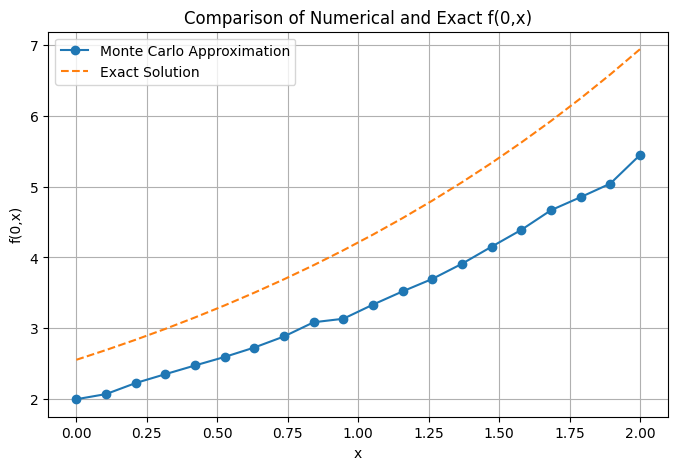

array([[0.        , 1.99656853, 2.55358946],
       [0.10526316, 2.06902887, 2.69158861],
       [0.21052632, 2.22516987, 2.8370454 ],
       [0.31578947, 2.35046457, 2.99036286],
       [0.42105263, 2.47350262, 3.15196578],
       [0.52631579, 2.59379068, 3.32230193],
       [0.63157895, 2.72687082, 3.50184325],
       [0.73684211, 2.88302496, 3.69108721],
       [0.84210526, 3.08396329, 3.89055815],
       [0.94736842, 3.13329669, 4.10080875],
       [1.05263158, 3.33318304, 4.32242155],
       [1.15789474, 3.520426  , 4.55601058],
       [1.26315789, 3.6961472 , 4.80222306],
       [1.36842105, 3.91022493, 5.06174116],
       [1.47368421, 4.15177005, 5.33528394],
       [1.57894737, 4.3892831 , 5.62360931],
       [1.68421053, 4.66681306, 5.92751615],
       [1.78947368, 4.85149439, 6.24784649],
       [1.89473684, 5.04307713, 6.58548787],
       [2.        , 5.44711686, 6.94137582]])

In [18]:
# Exact f(0,x)
f0_exact = np.exp(xs/2 + 15/16)

plt.figure(figsize=(8,5))
plt.plot(xs, f0_vals, 'o-', label="Monte Carlo Approximation")
plt.plot(xs, f0_exact, '--', label="Exact Solution")
plt.title("Comparison of Numerical and Exact f(0,x)")
plt.xlabel("x")
plt.ylabel("f(0,x)")
plt.grid(True)
plt.legend()
plt.show()

np.column_stack([xs, f0_vals, f0_exact])